<h1>Neural CLE Minimum Working Example<h1>

In [1]:
import Pkg; Pkg.activate("."); Pkg.instantiate(verbose=true)

  Activating project at `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs`
Precompiling project...
  ✓ CUDA_Runtime_jll
  ✓ CUDNN_jll
  ✓ CUDA
  ✓ CUDAKernels
  ✓ cuDNN
  ✓ NNlibCUDA
  ✓ LuxCUDA
  ✓ LuxLib
  ✓ Flux
  ✓ Lux
  ✓ OptimizationFlux
  ✓ DiffEqFlux
  12 dependencies successfully precompiled in 592 seconds (422 already precompiled, 1 skipped during auto due to previous errors)


In [2]:
Pkg.status()

      Status `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [13f3f980] CairoMakie v0.9.4
  [b0b7db55] ComponentArrays v0.13.8
  [8f4d0f93] Conda v1.8.0
  [aae7a2af] DiffEqFlux v1.54.0
  [77a26b50] DiffEqNoiseProcess v5.16.0
  [0c46a032] DifferentialEquations v7.7.0
  [31c24e10] Distributions v0.25.86
  [587475ba] Flux v0.13.14
  [f6369f11] ForwardDiff v0.10.35
  [7073ff75] IJulia v1.24.0
  [4138dd39] JLD v0.13.3
  [b964fa9f] LaTeXStrings v1.3.0
  [dde8697e] MakiePublication v0.3.1
  [872c559c] NNlib v0.8.19
  [73a701b4] NamedTuples v5.0.0
  [429524aa] Optim v1.7.4
  [3bd65402] Optimisers v0.2.17
  [7f7a1694] Optimization v3.13.0
  [253f991c] OptimizationFlux v0.1.2
  [91a5bcdd] Plots v1.38.8
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [731186ca] RecursiveArrayTools v2.38.3
  [1ed8b502] SciMLSensitivity v7.28.1
  [e88e6eb3] Zygote v0.6.59


In [3]:
using DiffEqFlux
using SciMLSensitivity
using Optimization
using DifferentialEquations.StochasticDiffEq
using DifferentialEquations.DiffEqCallbacks
using DiffEqNoiseProcess
using Statistics, LinearAlgebra, Random
using Plots
using RecursiveArrayTools
using DifferentialEquations.DiffEqBase.EnsembleAnalysis
using BenchmarkTools
using LaTeXStrings
using Printf # print formatting
using ForwardDiff

[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]


We are interested in the Birth-Death system, which could be used to describe the population dynamics of a system of cells that has both a growth and death term proportional to its current population. The mathematics of the single ODE system are as follows:

$\frac{dX}{dt} = \alpha_1 X - \alpha_2 X$

For our purposes, what we are trying to show is that we can observe parts of the ODE from viewing the final output. So we rearrage this system for convenience (and generalizability)

$\frac{dX}{dt} = R_1 - R_2$

$\frac{dT_1}{dt} = R_1$

$\frac{dT_2}{dt} = R_2$

$R_1 = \alpha_1 X$

$R_2 = \alpha_2 X$

Where $T_1$ and $T_2$ are cumulative reaction rate curves. If we can predict these from the observable data (X), it is equivalent to being able to predict the reaction rates. We can generate training data for $X_0$ = 50, $\alpha_1$ = 0.2, $\alpha_2$ = 0.1. 

The CLE of this system would look like:
$\frac{dS}{dt} = \begin{bmatrix}
R_1 - R_2\\
R_1\\
R_2\\
\end{bmatrix} dt + 
\begin{bmatrix}
\sqrt{R_1} & -\sqrt{R_2}\\
\sqrt{R_1} & 0\\
0 & \sqrt{R_2}\\
\end{bmatrix}dW$

After we construct training data, the goal is to fit the CLE to the data using a neural network to predict $R_1$ and $R_2$.

# True System given in Baker et al.

The CLE and first and second moments (expectation, and ) for $\frac{dX}{dt} = \alpha_1 X - \alpha_2 X$ is given by:

$$
\mathsf{d}X = (\alpha_1 -\alpha_2)X \mathsf{d}t + \sqrt{(\alpha_1 + \alpha_2)X}\mathsf{d}W
$$

$$
\dfrac{\mathsf{d}m_1}{\mathsf{d}t} = (\alpha_1 -\alpha_2)m_1
$$

$$
\dfrac{\mathsf{d}m_2}{\mathsf{d}t} = 2(\alpha_1 -\alpha_2)m_2 + (\alpha_1 +\alpha_2)m_1
$$

In [4]:
u0 = Float64[50.; 0.;0]
datasize = 201
tspan = (0.0f0, 10.0f0)
tsteps = range(tspan[1], tspan[2], length = datasize)

0.0f0:0.05f0:10.0f0

# Base solution of SDE is slow.

Possible improvements, not all performance-focused (for more details, see https://book.sciml.ai/notes/02-Optimizing_Serial_Code/):
0. it is customary to use `!` at end of functions in julia that modify their own inputs, an indication of constant memory access
1. remove branch conditions, e.g., `if u[1]>1000;end`, replace with an early termination callback
2. don't hardcode params, feed in through `p` in log form to maintain positivity constraints (will be more expensive to run with `log->exp` transform on each model parameter)
3. can try to improve data containers used, e.g., instead of mutating arrays, use `StaticArrays` (however, this will complicate downstream autodiff)
4. don't specify `dt` explicitly, otherwise you lose out on adaptive time stepping; this depends on whether solver supports adaptive time-stepping (as well as the noise structure, which is non-diagonal here); `EM()` (Euler-Murayama) does not support adaptive time-stepping, but `LambaEM()` does (see solvers here: https://docs.sciml.ai/DiffEqDocs/stable/solvers/sde_solve/)
5. might want to consider a non-stiff solver with adaptive time-stepping capable of handling non-diagonal noise such as `ImplicitEulerHeun()`
6. see also `SKenCarp()` for higher order stiff solver (non-adaptive), or `SRA2()` for higher order non-stiff solver (adaptive) (`SKenCarp()` and `SRA3()` did not work when tested and investigated, so much for higher order SDE solvers...)
7. declare types for your arguments to the functions upfront, e.g., type-explicitness! hopefully this doesn't screw up downstream autodiff typing (NOTE: you must also then specify types of ICs correctly, e.g., `zeros(Int64, 3, 2)` instead of `zeros(3, 2)` which defaults to `Float64`)
8. remove indexing into the noise structure parts `R1` and `R2`, i.e., `du[1, 1] = sqrt.(R1)[1]` to `du[1, 1] = sqrt.(R1)` (turns out the Julia's LLVM compiler was smart enough to remove the redundant indexing beforehand, so no change to the speed)
9. don't confuse the JIT compiler by introducing types in the data structures that did not have that typecasting, e.g., when defining the noise structure for the `du` matrix, using `0.0` instead of `0` for the empty cells, or simply not updating the value at all
10. eliminating the broadcasting `.` on operations that are scalar in nature, e.g., `du[1, 1] = sqrt(R1)` instead of `du[1, 1] = sqrt.(R1)`
11. `@inbounds` with `begin` and `end` block statements disables bounds checking for your code (bounds checking means Julia sees if you are indexing outside of your array into memory that isn't allocated to the array, and Julia does this for every heap-allocated object); only use this at the end of your code development/debugging once you are sure your code cannot index outside of a given memory structure

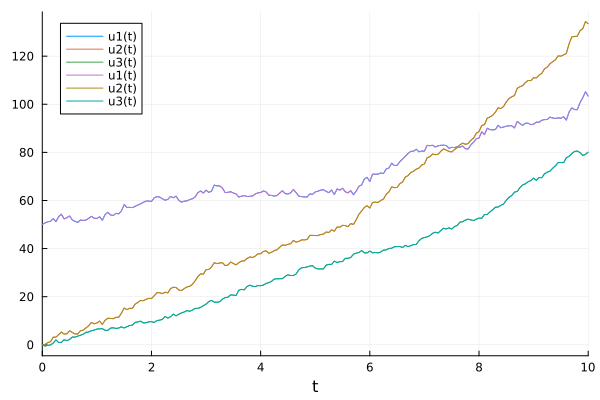

In [5]:
# old implementation
function trueSDEfunc(du, u, p, t)
    # α_1 = 0.2, α_2 = 0.1
    R1 = 0.2*u[1]
    R2 = 0.1*u[1]
    #Safety valve to prevent divergence to unstable values
    if u[1]>1000
        du[1] = 0
    else
        du[1] = R1-R2
    end
    du[2] = R1
    du[3] = R2
end

# old implementation
function true_noise_func(du, u, p, t)
    # α_1 = 0.2, α_2 = 0.1
    R1 = 0.2*u[1]
    R2 = 0.1*u[1]
    du[1, 1] = sqrt.(R1)[1]
    du[1, 2] = -sqrt.(R2)[1]
    du[2, 1] = sqrt.(R1)[1]
    du[3, 2] = 0
    du[3, 1] = 0
    du[3, 2] = sqrt.(R2)[1]
end
prob_truesde = SDEProblem(trueSDEfunc, true_noise_func, [50,0,0], tspan, noise_rate_prototype = zeros(3, 2), seed=1)
nothing

sol1 = solve(prob_truesde, EM(), dt=0.05)
sol2 = solve(prob_truesde, EM(), dt=0.05)
plot(sol1)
plot!(sol2)

In [6]:
@which LambaEM() # use this to check exact location in code and whether there are additional args to pass, looks like only split=true

LambaEM() in StochasticDiffEq at /home/kkganko/.julia/packages/StochasticDiffEq/rZj4R/src/algorithms.jl:55

In [7]:
# @btime sin.(randn(100))

In [8]:
# # new implementation that can't handle Dual numbers for autodiff...
# function trueSDEfunc!(
#         du::Vector{T},
#         u::Vector{T},
#         p::Vector{T},
#         t::Float64
# ) where {T<:Float64}
    
#     # α_1 = 0.2, α_2 = 0.1
#     R1 = exp(p[1])*u[1]
#     R2 = exp(p[2])*u[1]
#     du[1] = R1-R2
#     du[2] = R1
#     du[3] = R2
# end

# # new implementation that can't handle Dual numbers for autodiff...
# function true_noise_func!(
#         du::Matrix{T},
#         u::Vector{T},
#         p::Vector{T},
#         t::Float64
# ) where {T<:Float64}
    
#     # α_1 = 0.2, α_2 = 0.1
#     R1 = exp(p[1])*u[1]
#     R2 = exp(p[2])*u[1]
#     du[1, 1] = sqrt(R1)
#     du[1, 2] = -sqrt(R2)
#     du[2, 1] = sqrt(R1)
#     du[3, 2] = sqrt(R2)
# end

# new implementation that can handle Dual numbers for autodiff, i.e., with ForwardDiff.Dual
# some algs tested below require this functionality: ImplicitEulerHeun especially
function trueSDEfunc!(
        du::Vector{T1},
        u::Vector{T2},
        p::Vector{T3},
        t::Float64
) where {T1<:Union{ForwardDiff.Dual,Float64},T2<:Union{ForwardDiff.Dual,Float64},T3<:Union{ForwardDiff.Dual,Float64}}
    
    @inbounds begin
        # α_1 = 0.2, α_2 = 0.1
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[1]
        du[1] = R1-R2
        du[2] = R1
        du[3] = R2
    end
end

# new implementation that can't handle Dual numbers for autodiff...
function true_noise_func!(
        du::Matrix{T1},
        u::Vector{T2},
        p::Vector{T3},
        t::Float64
) where {T1<:Union{ForwardDiff.Dual,Float64},T2<:Union{ForwardDiff.Dual,Float64},T3<:Union{ForwardDiff.Dual,Float64}}
    
    @inbounds begin
        # α_1 = 0.2, α_2 = 0.1
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[1]
        du[1, 1] = sqrt(R1)
        du[1, 2] = -sqrt(R2)
        du[2, 1] = sqrt(R1)
        du[3, 2] = sqrt(R2)
    end
end

# callbacks
terminate_condition(u,t,integrator) = (u[1] > 1000.0)
affect_solver!(integrator) = terminate!(integrator, ReturnCode.Terminated) # can't use symbols for retcodes anymore, need to reference directly from ReturnCode object
cb_stop_solver = DiscreteCallback(terminate_condition,affect_solver!)
cbs = CallbackSet(cb_stop_solver)

# set up problem: initial conditions, params, solver hyperparams
datasize = 201
tspan = (0.0, 10.0)
tsteps = range(tspan[1], tspan[2], length = datasize)

u_0 = Float64[
    50.0,
    0.0,
    0.0
]
p_true = log.(Float64[
    0.2,
    0.1
])

# put an integer-valued seed to reproduce behavior
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = zeros(Float64, 3, 2),
    callback=cbs,
    seed=1
)

println("Old implementation EM:")
prob_truesde_old = SDEProblem(trueSDEfunc, true_noise_func, [50.0,0.0,0.0], tspan, noise_rate_prototype = zeros(3, 2), seed=1)
b0 = @benchmark sol0 = solve(prob_truesde_old, EM(), dt=0.05)
display(b0)

println("New implementation EM:")
b1 = @benchmark sol1 = solve(prob_truesde, EM(), dt = 0.05)
display(b1)

println("LambaEM w/o guess on initial dt:")
b2 = @benchmark sol2 = solve(prob_truesde, LambaEM())
display(b2)

println("LambaEM w/ guess on initial dt:")
b3 = @benchmark sol3 = solve(prob_truesde, LambaEM(), dt=0.05)
display(b3)

println("ImplicitEulerHeun w/o guess on initial dt:")
b4 = @benchmark sol4 = solve(prob_truesde, ImplicitEulerHeun())
display(b4)

println("LambaEulerHeun adaptive:")
b5 = @benchmark  sol5 = solve(prob_truesde, LambaEulerHeun())
display(b5)

println("SRA2 for higher order non-stiff solver (adaptive):")
b6 = @benchmark sol6 = solve(prob_truesde, SRA2())
display(b6)

Old implementation EM:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  33.400 μs …  36.353 ms  ┊ GC (min … max): 0.00% … 99.79%
 Time  (median):     40.800 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   45.121 μs ± 363.177 μs  ┊ GC (mean ± σ):  8.04% ±  1.00%

             ▄▄▆▆█▃▁                                            
  ▂▂▄▆█▇▅▅▄▆▆███████▇▆▄▃▂▃▂▂▂▂▂▁▁▁▁▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  33.4 μs         Histogram: frequency by time         64.9 μs <

 Memory estimate: 22.86 KiB, allocs estimate: 261.

New implementation EM:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  44.300 μs …  2.532 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     51.000 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   52.328 μs ± 25.917 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▄▂█▆▃▁▁▄▄▆▆▃▂                                             
  ▃▅███████████████▇▅▅▄▃▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂ ▄
  44.3 μs         Histogram: frequency by time        79.9 μs <

 Memory estimate: 23.02 KiB, allocs estimate: 265.

LambaEM w/o guess on initial dt:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  63.100 μs …  48.126 ms  ┊ GC (min … max): 0.00% … 99.77%
 Time  (median):     75.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   82.211 μs ± 482.866 μs  ┊ GC (mean ± σ):  5.84% ±  1.00%

           █▅▆▄▁                                                
  ▅▅▅▆█▆▅▄▇█████▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  63.1 μs         Histogram: frequency by time          130 μs <

 Memory estimate: 23.14 KiB, allocs estimate: 255.

LambaEM w/ guess on initial dt:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  36.100 μs …  10.775 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     49.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   69.976 μs ± 280.892 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     █▂                                                         
  ▃▂███▆▄▃▂▂▂▂▂▂▃▃▃▄▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  36.1 μs         Histogram: frequency by time          164 μs <

 Memory estimate: 13.47 KiB, allocs estimate: 133.

ImplicitEulerHeun w/o guess on initial dt:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  264.000 μs …  34.282 ms  ┊ GC (min … max): 0.00% … 98.30%
 Time  (median):     331.200 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   369.976 μs ± 563.164 μs  ┊ GC (mean ± σ):  2.48% ±  1.69%

      ▅█▅▃▁▁                                                     
  ▃▃▃▇███████▆▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  264 μs           Histogram: frequency by time          828 μs <

 Memory estimate: 62.41 KiB, allocs estimate: 881.

LambaEulerHeun adaptive:


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  154.700 μs …  30.775 ms  ┊ GC (min … max): 0.00% … 99.16%
 Time  (median):     188.300 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   199.581 μs ± 425.542 μs  ┊ GC (mean ± σ):  3.00% ±  1.40%

         ▁ █▄▂▃  ▄▁                                              
  ▃▂▃▂▃▄▅█▆█████████▆▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  155 μs           Histogram: frequency by time          316 μs <

 Memory estimate: 47.33 KiB, allocs estimate: 421.

SRA2 for higher order non-stiff solver (adaptive):


BenchmarkTools.Trial: 5688 samples with 1 evaluation.
 Range (min … max):  676.000 μs … 39.936 ms  ┊ GC (min … max): 0.00% … 95.48%
 Time  (median):     779.250 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   871.754 μs ±  1.059 ms  ┊ GC (mean ± σ):  3.43% ±  2.85%

    ▄▇▇█▇▆▆▅▅▄▄▃▃▃▂▂▂▁▁                                        ▂
  ██████████████████████▇█▇▇▆▇▇▆▇▇▇▆▆▆▆▇▆▆▆▆▆▆▆▆▆▇▆▆▅▆▆▃▆▆▅▅▅▅ █
  676 μs        Histogram: log(frequency) by time      1.62 ms <

 Memory estimate: 168.08 KiB, allocs estimate: 1611.

In [9]:
# parallelized computation of results

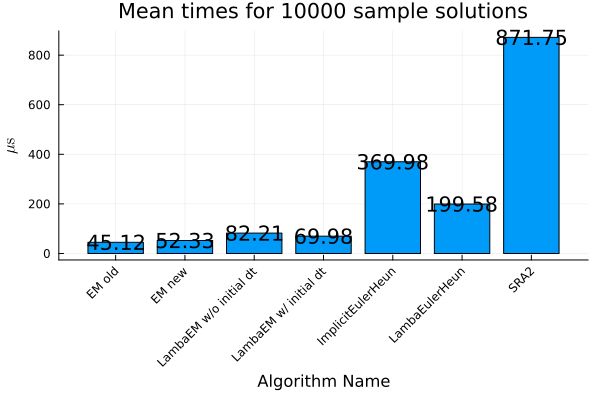

In [10]:
# summary of benchmarked results
alg_names = [
    "EM old", 
    "EM new",
    "LambaEM w/o initial dt",
    "LambaEM w/ initial dt",
    "ImplicitEulerHeun",
    "LambaEulerHeun",
    "SRA2"
]
sde_solver_comparison_p = plot()

b_res = [b0,b1,b2,b3,b4,b5,b6]
b_meantimes = Float64[]
for (i,name) in enumerate(alg_names)
    push!(b_meantimes, mean(b_res[i].times))
end
# convert times from ns to μs
b_meantimes /= 1.0e3 
annotations = map(x->@sprintf("%.2f",x), b_meantimes)

bar!(
    sde_solver_comparison_p,
    b_meantimes,
    label = "",
    xticks = (1:length(alg_names),alg_names), # enumerate and label xticks
    xrotation = 45, # rotate xtick labels
    xlabel = "Algorithm Name",
    ylabel = L"$\mu \textrm{s}$",
    text = annotations,
    textposition="top center",
    bottommargin = 10*Plots.mm,
    title = "Mean times for $(b1.params.samples) sample solutions"
)

In [11]:
@which SRA2()

SRA2() in StochasticDiffEq at /home/kkganko/.julia/packages/StochasticDiffEq/rZj4R/src/algorithms.jl:338

In [12]:
# compare accuracies of results
sol0 = solve(prob_truesde_old, EM(), dt=0.05)
sol1 = solve(prob_truesde, EM(), dt = 0.05)
sol2 = solve(prob_truesde, LambaEM())
sol3 = solve(prob_truesde, LambaEM(), dt=0.05)
sol4 = solve(prob_truesde, ImplicitEulerHeun())
sol5 = solve(prob_truesde, LambaEulerHeun())
sol6 = solve(prob_truesde, SRA2())
solns = [sol0,sol1,sol2,sol3,sol4,sol5,sol6]
alg_names = ["EM old" "EM new" "LambaEM w/o initial dt" "LambaEM w/ initial dt" "ImplicitEulerHeun" "LambaEulerHeun" "SRA2"]

compare_sde_solns_p = plot(size = (900,600),legend = :outerright)
for (i,sol) in enumerate(solns)
    plot!(
        compare_sde_solns_p,
        sol,
        label=alg_names[i],
        markershape = :circle,
        markerstrokecolor=i, # color of the markerstroke outline
        color=i
    )
end

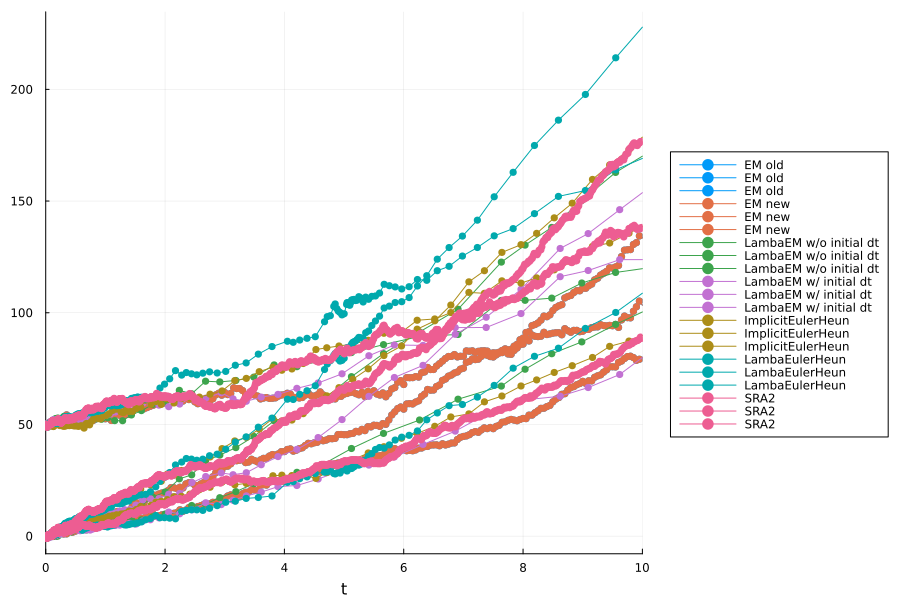

In [13]:
# extremely laggy to plot this...
compare_sde_solns_p[1].plt

# Observations investigating computation of single samples (SDE solvers)

# 1) some are faster, some are slower, `LambaEM()` with initial `dt` specified is fastest, need to do ensemble analysis to get the accuracy characterized

# 2) even with the same random seeding, time-step adaptivity will cause different solvers to produce different single sample runs, due most probably to the stochastic element discretization changing for different time step sizes

# 3) higher order solvers require smaller timesteps to enhance accuracy, e.g., density of time points for `SRA2()` much higher than `EM()` throughout

We can generate a consistant testing set of means and variance by averaging an ensemble of function evaluations. 

In [14]:
prob_truesde = SDEProblem(trueSDEfunc, true_noise_func, [50,0,0], tspan, noise_rate_prototype = zeros(3, 2))
ensembleprob = EnsembleProblem(prob_truesde)
@time sol = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = 100000)
truemean = mean(sol, dims = 3)[:, :]
truevar = var(sol, dims = 3)[:, :];

 27.658696 seconds (33.06 M allocations: 3.218 GiB, 28.96% gc time, 26.34% compilation time)


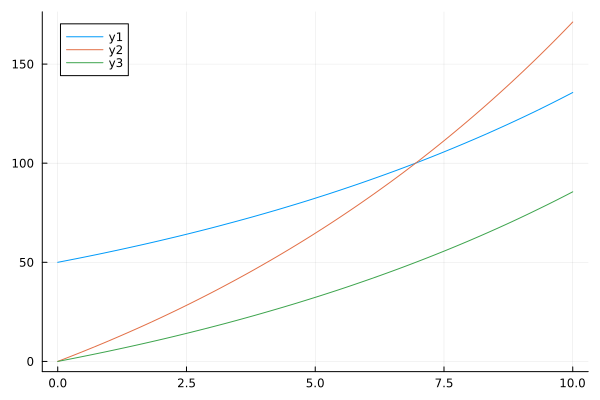

In [15]:
plot(LinRange(0,10,201),truemean')

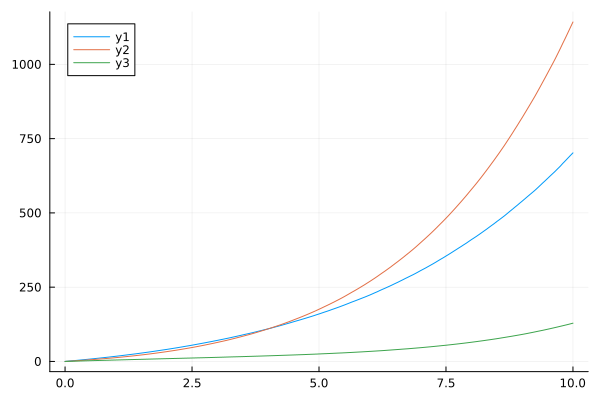

In [16]:
plot(LinRange(0,10,201),truevar')

# Comparing ensembles of simulations between solvers

In [18]:
# set up problem: initial conditions, params, solver hyperparams
u_0 = Float64[
    50.0,
    0.0,
    0.0
]
p_true = log.(Float64[
    0.2,
    0.1
])

# eliminate integer-valued seed when simulating ensembles
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = zeros(3, 2),
    callback=cbs,
)
ensemble_prob = EnsembleProblem(prob_truesde)
t_pts = Vector{Float64}[]
true_means = Matrix{Float64}[]
true_vars = Matrix{Float64}[]
NUM_TRAJECTORIES = 1000

# other way of computing the statistics for the ensemble
# mean([ensemble_sol0.u[i][:,:] for i in 1:length(ensemble_sol0.u)]) 
# var([ensemble_sol0.u[i][:,:] for i in 1:length(ensemble_sol0.u)])

# need saveat = 0.05 arg to ensure coherence in time of the inputs
println("Old implementation EM complete.")
prob_truesde_old = SDEProblem(trueSDEfunc, true_noise_func, [50,0,0], tspan, noise_rate_prototype = zeros(3, 2))
ensemble_prob_old = EnsembleProblem(prob_truesde_old)
ensemble_sol0 = solve(ensemble_prob_old, EM(), dt=0.05, trajectories = NUM_TRAJECTORIES, saveat = 0.05)
push!(t_pts, ensemble_sol0.u[1].t)
push!(true_means, mean(ensemble_sol0, dims = 3)[:, :]') # transpose to get plotting right
push!(true_vars, var(ensemble_sol0, dims = 3)[:, :]') # transpose to get plotting right

println("New implementation EM complete.")
ensemble_sol1 = solve(ensemble_prob, EM(), dt = 0.05, trajectories = NUM_TRAJECTORIES, saveat = 0.05)
push!(t_pts, ensemble_sol1.u[1].t)
push!(true_means, mean(ensemble_sol1, dims = 3)[:, :]') # transpose to get plotting right
push!(true_vars, var(ensemble_sol1, dims = 3)[:, :]') # transpose to get plotting right

println("LambaEM w/o guess on initial dt complete.")
ensemble_sol2 = solve(ensemble_prob, LambaEM(), trajectories = NUM_TRAJECTORIES, saveat = 0.05)
push!(t_pts, ensemble_sol2.u[1].t)
push!(true_means, mean(ensemble_sol2, dims = 3)[:, :]') # transpose to get plotting right
push!(true_vars, var(ensemble_sol2, dims = 3)[:, :]') # transpose to get plotting right

println("LambaEM w/ guess on initial dt complete.")
ensemble_sol3 = solve(ensemble_prob, LambaEM(), dt=0.05, trajectories = NUM_TRAJECTORIES, saveat = 0.05)
push!(t_pts, ensemble_sol3.u[1].t)
push!(true_means, mean(ensemble_sol3, dims = 3)[:, :]') # transpose to get plotting right
push!(true_vars, var(ensemble_sol3, dims = 3)[:, :]') # transpose to get plotting right

println("ImplicitEulerHeun w/o guess on initial dt complete.")
ensemble_sol4 = solve(ensemble_prob, ImplicitEulerHeun(), trajectories = NUM_TRAJECTORIES, saveat = 0.05)
push!(t_pts, ensemble_sol4.u[1].t)
push!(true_means, mean(ensemble_sol4, dims = 3)[:, :]') # transpose to get plotting right
push!(true_vars, var(ensemble_sol4, dims = 3)[:, :]') # transpose to get plotting right

println("LambaEulerHeun adaptive complete.")
ensemble_sol5 = solve(ensemble_prob, LambaEulerHeun(), trajectories = NUM_TRAJECTORIES, saveat = 0.05)
push!(t_pts, ensemble_sol5.u[1].t)
push!(true_means, mean(ensemble_sol5, dims = 3)[:, :]') # transpose to get plotting right
push!(true_vars, var(ensemble_sol5, dims = 3)[:, :]') # transpose to get plotting right

println("SRA2 for higher order non-stiff solver (adaptive) complete.")
ensemble_sol6 = solve(ensemble_prob, SRA2(), trajectories = NUM_TRAJECTORIES, saveat = 0.05)
push!(t_pts, ensemble_sol6.u[1].t)
push!(true_means, mean(ensemble_sol6, dims = 3)[:, :]') # transpose to get plotting right
push!(true_vars, var(ensemble_sol6, dims = 3)[:, :]') # transpose to get plotting right
nothing

Old implementation EM complete.
New implementation EM complete.
LambaEM w/o guess on initial dt complete.
LambaEM w/ guess on initial dt complete.
ImplicitEulerHeun w/o guess on initial dt complete.
LambaEulerHeun adaptive complete.
SRA2 for higher order non-stiff solver (adaptive) complete.


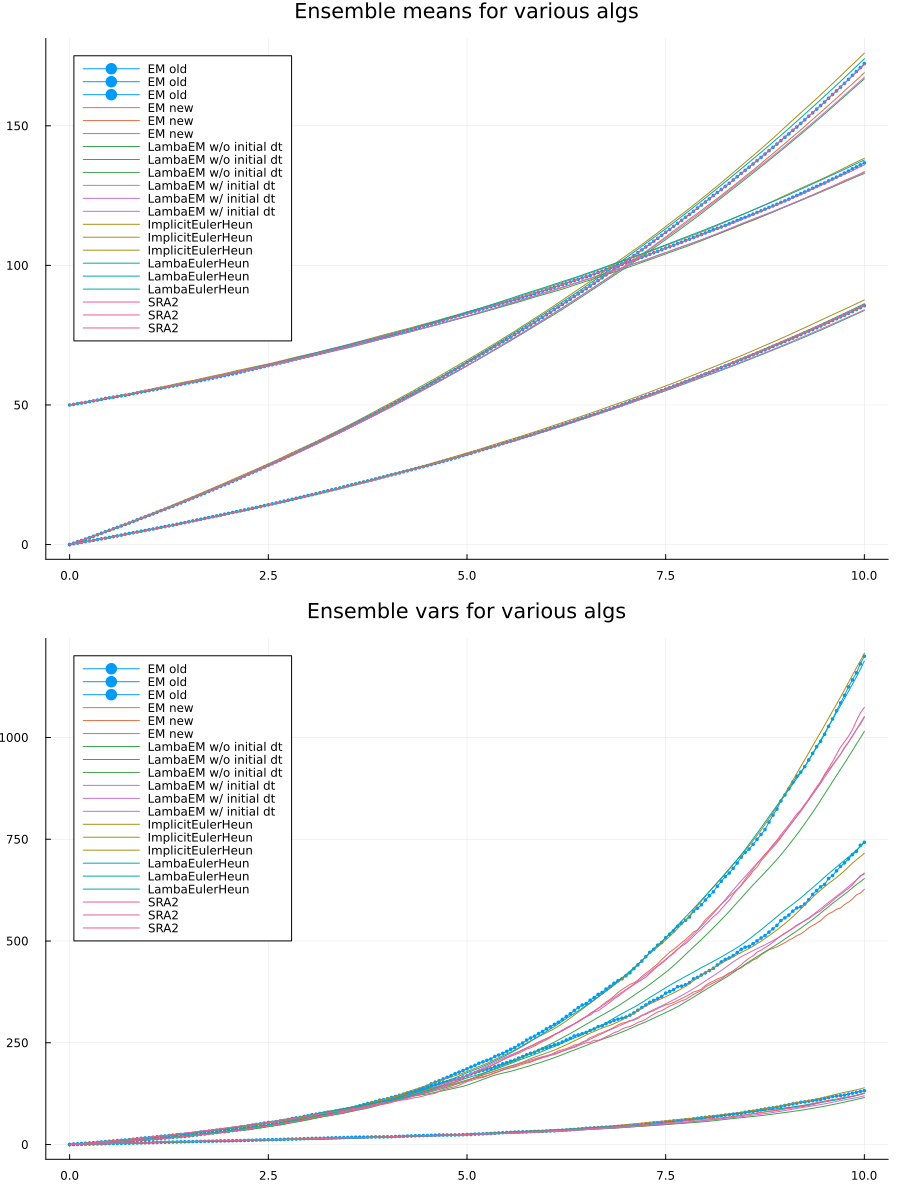

In [19]:
compare_ensemblemeans_p = plot(title = "Ensemble means for various algs")
compare_ensemblevars_p = plot(title = "Ensemble vars for various algs")
alg_names = ["EM old" "EM new" "LambaEM w/o initial dt" "LambaEM w/ initial dt" "ImplicitEulerHeun" "LambaEulerHeun" "SRA2"]

for (i, times) in enumerate(t_pts)
    plot!(
        compare_ensemblemeans_p,
        times,
        true_means[i],
        color = i,
        label=alg_names[i],
        markershape = ifelse(i==1,:circle,:none),
        markersize = 2,
        markerstrokecolor = i
    )
    
    
    plot!(
        compare_ensemblevars_p,
        times,
        true_vars[i],
        color = i,
        label=alg_names[i],
        markershape = ifelse(i==1,:circle,:none),
        markersize = 2,
        markerstrokecolor = i
    )
end

plot(
    compare_ensemblemeans_p,
    compare_ensemblevars_p,
    layout = (2,1),
    size = (900,1200)
)

# Observations: Variance statistics are more variable than mean statistics, so any info delivered from running NN approximations of the system structure will have poorer reconstruction of true model variance due to numerical errors

## Varying number of ensemble solutions to get approximate solutions

If you can get away with running `N=100` simulations to get an appropriate mean and variance of an SDE, why run `N=1000`? Formally, we pose the question:

***How many solutions in the ensemble are sufficient to produce approximate statistics for the SDE to be used in the Neural Network training?***

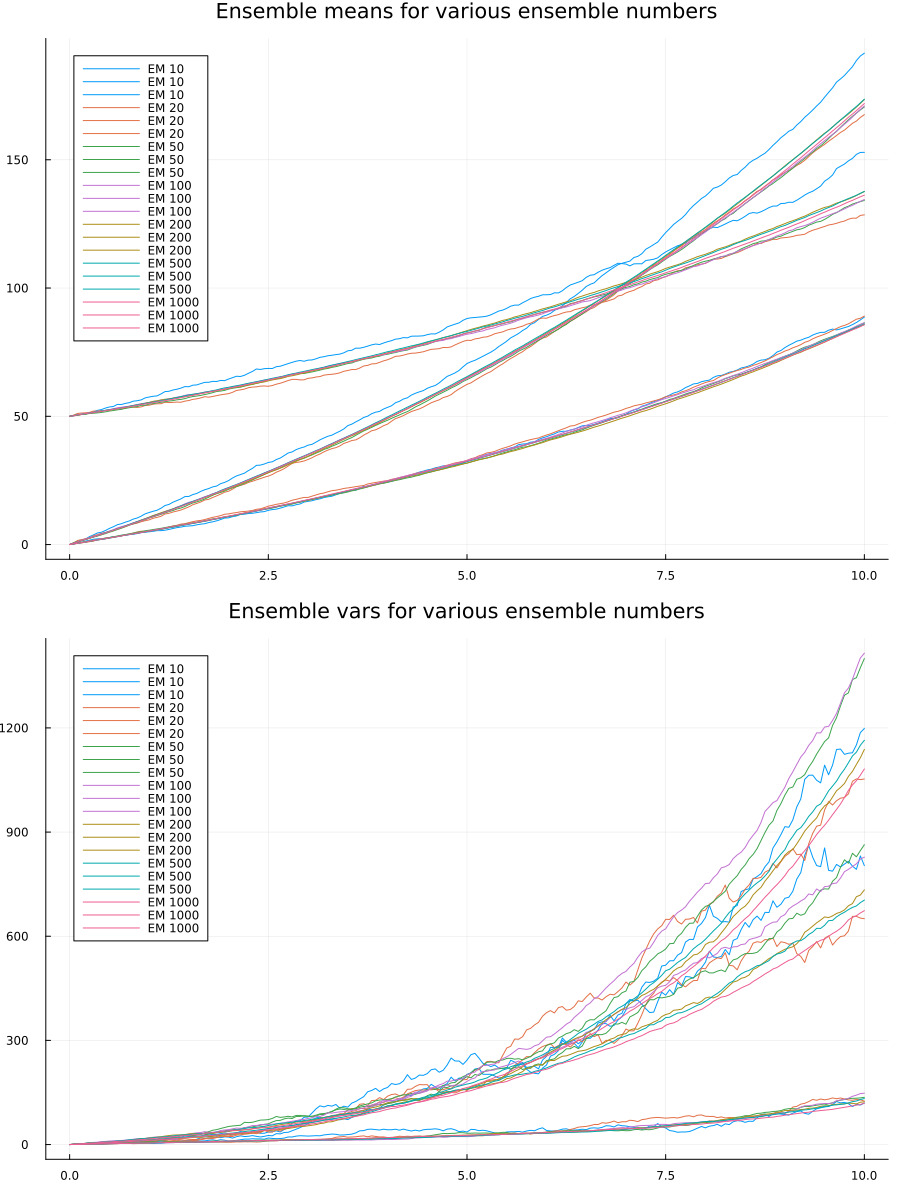

In [20]:
compare_trajnums_mean_p = plot(title = "Ensemble means for various ensemble numbers")
compare_trajnums_vars_p = plot(title = "Ensemble vars for various ensemble numbers")

trajectory_numbers = [10,20,50,100,200,500,1000]
vary_trajs_t_pts = Vector{Float64}[]
vary_trajs_true_means = Matrix{Float64}[]
vary_trajs_true_vars = Matrix{Float64}[]


for (i,NUM_TRAJECTORIES) in enumerate(trajectory_numbers)
    ensemble_sol1 = solve(ensemble_prob, EM(), dt = 0.05, trajectories = NUM_TRAJECTORIES, saveat = 0.05)
    push!(vary_trajs_t_pts, ensemble_sol1.u[1].t)
    push!(vary_trajs_true_means, mean(ensemble_sol1, dims = 3)[:, :]') # transpose to get plotting right
    push!(vary_trajs_true_vars, var(ensemble_sol1, dims = 3)[:, :]') # transpose to get plotting right
    
    plot!(
        compare_trajnums_mean_p,
        ensemble_sol1.u[1].t,
        vary_trajs_true_means[end],
        color = i,
        label = "EM "*string(NUM_TRAJECTORIES)
    )
    
    plot!(
        compare_trajnums_vars_p,
        ensemble_sol1.u[1].t,
        vary_trajs_true_vars[end],
        color = i,
        label = "EM "*string(NUM_TRAJECTORIES)
    )
end

plot(
    compare_trajnums_mean_p,
    compare_trajnums_vars_p,
    layout = (2,1),
    size = (900,1200)
)


# Observations: again, numerical experiments show that the variance statistics is more sensitive to the trajectory number than the mean statistic for the same solver

Now we generate a neural SDE that can be trained on this data. We want to generate an SDEProblem that takes in two functions describing the drift and diffusion of our system. These functions, in turn, rely on the same neural network (with the same parameters) to predict the rates for them. Note that ratesmodel() only gets to access X.

In [294]:
function ratestodrift(u, p, t)
    R1,R2 = ratesmodel(u[1],p)
    #Safetly valve to keep bad parameter sets from crashing
    if abs(u[1])<1000
        reacprogress = R1-R2
    else
        reacprogress = 0
    end
    return [reacprogress,R1,R2]
end

function ratestodiff(u, p, t)
    R1,R2 = ratesmodel(u[1],p)
    return [[sqrt.(R1),sqrt.(R1),0] [-sqrt.(R2),0,sqrt.(R2)]]
end

ratestodiff (generic function with 1 method)

We define the neural network using FastChains, which explicitly requires you to pass in a vector of parameters. p_nn is a randomly generated set of parameters that can be used as a starting point. 

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux ~/.julia/packages/DiffEqFlux/jHIee/src/fast_layers.jl:9


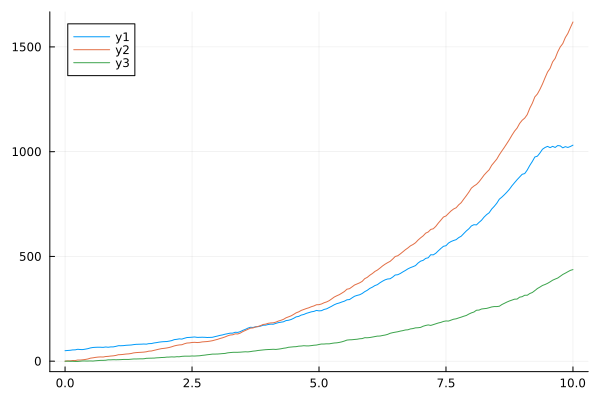

In [298]:
ratesmodel = FastChain(FastDense(1 , 16, relu), FastDense(16 , 2, relu));
p_nn = initial_params(ratesmodel);

prob = SDEProblem(ratestodrift, ratestodiff, u0, tspan, p_nn, noise_rate_prototype=zeros(3,2))
sol = solve(prob,EM(),dt = 0.05;sensealg=TrackerAdjoint())
plot(sol.t,Array(sol)')

In [292]:
function getprediction(p,u=u0)
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype=zeros(3,2))
    sol = solve(prob,EM(),dt = 0.05;sensealg=TrackerAdjoint())
    if (sol.retcode != ReturnCode.Success)
        print(p)
    end
    return Array(sol)
end

function predict_batch_neuralsde(p, n)
    res = map((x->getprediction(p,x)),[u0 for i in 1:n])
    VA = VectorOfArray(res)
    arr = convert(Array,VA)
end

function predictmeanvar(p,n)
    samples = predict_batch_neuralsde(p,n)
    means = mean(samples, dims = 3)
    vars = var(samples, dims = 3, mean = means)
    return means,vars
end

function loss_neuralsde(p; n = 100)
  means,vars = predictmeanvar(p,n)
  testmeans = means[1,:,:]
  testvars = vars[1,:,:]
  loss = sum(abs2, truemean[1,:] - testmeans) + sum(abs2, p) + sum(abs2, truevar[1,:] - testvars)
  return loss#, means, vars
end
#test = Zygote.gradient(loss_neuralsde,p_nn)

loss_neuralsde (generic function with 1 method)

Now that we have a loss function described, we can train our neural network. I had to set the training rate hyperparameter very low to avoid weird divergence in parameter updates. As such it takes a long time. The plots below shows the results - specifically (hopefully), that as the model converges to the testing data (X means and vars) it also converges to showing the hidden values correctly (R1 and R2 (cumulative)).

In [687]:
opt = ADAM(0.0001)

# First round of training with n = 10
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p_nn)#Change to p_nn if first time running
result1 = Optimization.solve(optprob, opt, maxiters = 1000);

In [688]:
loss_neuralsde(p_nn) #Inital parameter guess

8.450435625903767e6

In [689]:
loss_neuralsde(result1.u) #Parameters after training

41499.16386260459

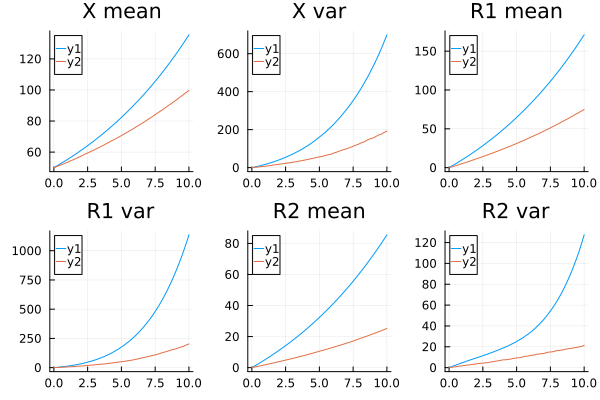

In [690]:
predres = predictmeanvar(p_nn,1000)#Inital parameter guess
plt1 = plot(tsteps,[truemean[1,:],predres[1][1,:,:]],title="X mean")
plt2 = plot(tsteps,[truevar[1,:],predres[2][1,:,:]],title="X var")
plt3 = plot(tsteps,[truemean[2,:],predres[1][2,:,:]],title="R1 mean")
plt4 = plot(tsteps,[truevar[2,:],predres[2][2,:,:]],title="R1 var")
plt5 = plot(tsteps,[truemean[3,:],predres[1][3,:,:]],title="R2 mean")
plt6 = plot(tsteps,[truevar[3,:],predres[2][3,:,:]],title="R2 var")
plot(plt1,plt2,plt3,plt4,plt5,plt6)

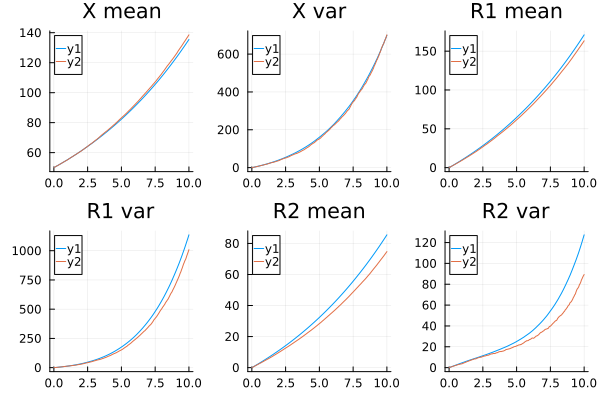

In [691]:
predres = predictmeanvar(result1.u,1000)#Parameters after training
plt1 = plot(tsteps,[truemean[1,:],predres[1][1,:,:]],title="X mean")
plt2 = plot(tsteps,[truevar[1,:],predres[2][1,:,:]],title="X var")
plt3 = plot(tsteps,[truemean[2,:],predres[1][2,:,:]],title="R1 mean")
plt4 = plot(tsteps,[truevar[2,:],predres[2][2,:,:]],title="R1 var")
plt5 = plot(tsteps,[truemean[3,:],predres[1][3,:,:]],title="R2 mean")
plt6 = plot(tsteps,[truevar[3,:],predres[2][3,:,:]],title="R2 var")
plot(plt1,plt2,plt3,plt4,plt5,plt6)

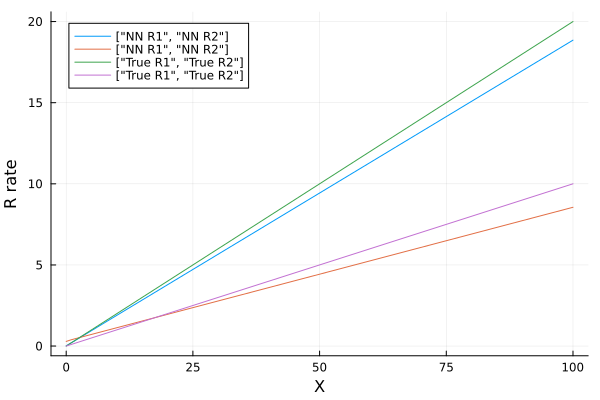

In [709]:
res = [ratesmodel(x,result1.u) for x in testX]
VA = VectorOfArray(res)
arr = convert(Array,VA)
plot(testX, arr[:,1,:]',xlabel = "X",ylabel = "R rate",label = ["NN R1"; "NN R2"])
plot!(testX, [0.2*testX,0.1*testX],label = ["True R1"; "True R2"])
